<a href="https://colab.research.google.com/github/min207/2023-1-ESAA/blob/main/ESAA230310.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **CH03. 분류**
----------------------------
### **3.1 MNIST**
- MNIST: 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지를 모은 데이터셋, 레이블 o

In [41]:
import numpy as np
import pandas as pd

# 데이터셋 불러오기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, as_frame = False) # as_frame 인자 추가해야 X[0]에서 key error 안남
mnist.keys()

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

> 사이킷런에서 읽어들인 데이터셋은 일반적으로 비슷한 딕셔너리 구조를 가짐
  - 데이서텟을 설명하는 DESCR 키
  - 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
  - 레이블 배열을 담은 target 키

In [42]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


> 이미지는 70,000개, 그리고 각 이미지에는 784개의 특성이 존재 (이미지는 28*28 픽셀)
- 개개의 특성은 0 ~ 255로 흰색부터 검은색까지의 픽셀 강도를 의미

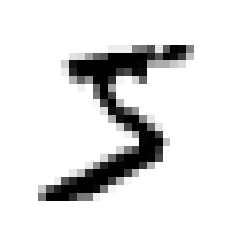

In [43]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0] # 이미지 지정 후 확인인
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [44]:
y[0] # 실제 레이블 확인

'5'

In [45]:
y = y.astype(np.uint8) # 문자열 -> 정수 변환

** 주의할 점: 데이터 조사 전 테스트 세트를 별도로 떼어놓아야함. MNIST 데이터셋은 훈련 세트(60,000)와 테스트 세트(10,000)로 구성


- 데이터셋을 섞는 것을 통해 비슷한 샘플이 연이어 나타나 학습 알고리즘의 성능이 나빠지는 것을 방지

In [46]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

-----------------------

### **3.2 이진 분류기 훈련**

- 이진 분류기: 하나의 숫자를 식별하는 것처럼(ex. 5인 것과 5가 아닌 것) 두 개의 클래스를 구분

In [47]:
# 타깃 벡터 생성
y_train_5 = (y_train == 5) # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

> 사이킷런의 SGDClassifier 클래스를 사용해 확률적 경사 하강법(SGD) 분류기로 훈련
  - 매우 큰 데이터셋을 효율적으로 처리 가능
    + SGD는 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문

In [48]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [49]:
# 모델을 통해 숫자 5 이미지 감지
sgd_clf.predict([some_digit])

array([ True])

> 위에서 지정한 이미지가 5를 나타낸다고 맞게 추측

--------------------------

### **3.3 성능 측정**

#### 3.3.1 교차 검증을 사용한 정확도 측정
- 교차 검증 과정을 더 많이 제어할 필요가 있는 경우, 교차 검증 기능을 직접 구현

In [50]:
# 사이킷런의 cross_val_score()과 비슷한 작업을 수행/출력하는 코드
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True) # error가 떠서 shuffle = True 설정

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


> StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링 수행/ 분류기 객체를 복제하여 훈련/예측 후 올바른 예측의 수를 세어 정확한 예측의 비율 출력

In [51]:
# cross_val_score()를 이용해 모델 성능 평가
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

> 모든 교차 검증 폴드에 대한 정확도가 95% 이상 >> 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기와 비교

In [52]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

# 모델의 정확도 추측
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

> 모두 정확도 90% 이상 >> 이미지의 약 10% 정도만 숫자 5인 불균형한 데이터셋이기 때문
  - 따라서 정확도를 분류기의 성능 측정 지표로 적합하지 않음
    + 특히 불균형한 데이터셋인 경우



#### 3.3.2 오차 행렬
- 오차 행렬: 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것
- 오차 행렬을 만들기 위해서는 실제 타깃과 비교할 예측값이 필요: cross_val_predict() 함수 사용 

In [53]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

> k-겹 교차 검증을 수행하지만 평가 점수 반환x, 각 테스트 폴드에서 얻은 예측 반환
- confusion_matrix() 함수를 통해 오차 행렬 생성

In [54]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

> - 오차 행렬의 행은 실제 클래스, 열은 예측한 클래스를 나타냄
    + 첫번째 행: 음성 클래스(negative class) / 두번째 행: 양성 클래스(positive class)
    + TN: 53,057 / '5 아님'으로 정확하게 분류
    + FP: 1,522 / '5'로 잘못 분류
    + FN: 1,325 / '5 아님'으로 잘못 분류
    + TP: 4,096 / '5'로 정확하게 분류

In [55]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

> 오차 행렬보다 더 요약된 지표가 필요할 경우 정밀도, 재현율 사용 가능
- 정밀도(precision): 양성 예측의 정확도
$$ precision= \frac{TP}{TP+FP}$$
- 재현율(recall): 분류기가 정확하게 감지한 양성 샘플의 비율, 정밀도와 상호 보완적으로 함께 사용
  + 민감도(sensitivity), 진짜 양성 비율(true positive rate, TPR)과 동일어
$$ recall = \frac{TP}{TP+FN}$$


#### 3.3.3 정밀도와 재현율

In [56]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred), # 정밀도 계산, == 4096 / (4096 + 1522)
recall_score(y_train_5, y_train_pred)) # 정밀도 계산 , == 4096 / (4096 + 1325)

0.8370879772350012 0.6511713705958311


> 5로 판별된 이미지 중 83.7%만 정확, 전체 숫자 5 중 65.1%만 감지
- F1 score: 정밀도와 재현율의 조화 평균(정밀도와 재현율을 하나의 숫자로 만든 것)
  + 두 분류기를 비교할 때 유용
  + 사이킷런의 f1_score() 함수를 통해 계산 가능
$$ F_1 = \frac{2}{\frac{1}{정밀도} + \frac{1}{재현율}} = 2 \times \frac{정밀도 \times 재현율}{정밀도 + 재현율} = \frac{TP}{TP + \frac{FN + FP}{2}}$$

In [57]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

> - 정밀도와 재현율이 비슷한 분류기는 F1 score가 높음
    + 그러나 상황에 따라 정밀도, 재현율의 중요도가 다르기 때문에 무조건 F1 score가 높아야만 하는 것은 아님
  - 정밀도와 재현율이 동시에 높은 것은 불가능: **정밀도/재현율 트레이드오프**



  #### 3.3.4 정밀도/재현율 트레이드오프
  - SGDClassifier은 결정 함수(decision function)을 사용하여 각 샘플의 점수를 계산 >> 점수가 임곗값보다 클 경우 샘플을 양성 클래스에 할당
  - 결정 임곗값(decision threshold)를 높이면 재현율이 낮아지고 정밀도가 높아짐
  - 사이킷런에서 임곗값을 직접 지정 불가능하지만, 예측에 사용한 점수 확인은 가능: decision_function() 메서드 사용

In [58]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [59]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

> SGDClassifier의 임곗값이 0이기 때문에 코드는 predict()와 같은 결과(True)를 반환

In [60]:
threshold = 8000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

> 임곗값을 높이자 False 반환: 임곗값을 높이면 재현율이 감소한다
- 적절한 임곗값을 구하기 위해 훈련 세트에 있는 모든 샘플의 점수 계산(결정 점수 반환 지정 필요)

In [61]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

> precision_recall_curve() 함수를 통해 가능한 모든 임곗값에 대한 정밀도와 재현율을 계산 후 시각화 >> 적절한 임곗값 발견

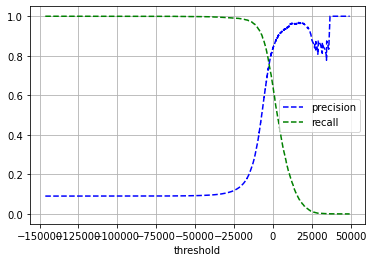

In [62]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="precision")
  plt.plot(thresholds, recalls[:-1], "g--", label="recall")
  plt.legend(loc="center right", fontsize=10)
  plt.xlabel("threshold", fontsize=10)
  plt.grid(True)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

> 정밀도가 급격하게 줄어드는 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋음

In [63]:
# 정밀도 90% 달성 목표
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)) # 정밀도, 재현율 확인

0.9000345901072293 0.4799852425751706


> 임곗값을 늘려 정밀도를 90% 이상으로 만들었으나, 재현율이 너무 낮은 분류기의 성능은 오히려 낮아짐



#### 3.3.5 ROC 곡선
- ROC 곡선(수신기 조작 특성 곡선): 이진 분류에서 널리 사용하는 도구로, 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)의 곡선
  + 즉, 민감도(재현율)에 대한 1-특이도(TNR) 그래프

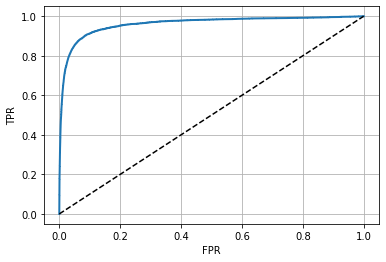

In [64]:
from sklearn.metrics import roc_curve # ROC 곡선을 그리기 위해 여러 임곗값에서 TRP과 FPR 계산 
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--') # 대각 점선
  plt.xlabel('FPR', fontsize=10) 
  plt.ylabel('TPR', fontsize=10)
  plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()

> 재현율(TPR)이 높을수록 분류기가 만드는 FPR이 늘어남 (트레이드오프)
- 점선은 완전한 랜덤 분류기의 ROC 곡선을 의미
  + 좋은 분류기는 점선에서 최대한 왼쪽 위 모서리로 떨어져 있어야함

- 곡선 아래의 면적(AUC)를 측정하여 분류기 비교 가능
  + 완벽한 분류기는 ROC의 AUC가 1
  + 완전한 랜덤 분류기는 ROC의 AUC가 0.5

In [65]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

> RandomForestClassifier을 훈련시켜 SGDClassifier의 ROC 곡선과 ROC AUC 점수 비교
- predict_proba(): 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환

In [66]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

> ROC 곡선 시각화 

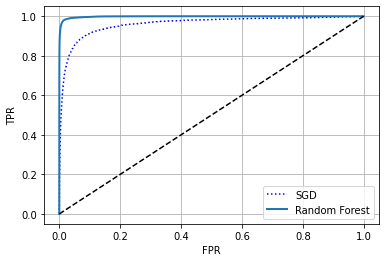

In [67]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

> RandomForestClassifier의 ROC 곡선이 더 왼쪽 위 모서리와 가까운 것으로 보아 성능이 더 좋음 

In [68]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

> RandomForestClassifier의 ROC AUC 점수가 훨씬 높음
- 정밀도와 재현율 점수를 계산하면 99.0%와 86.6%로 나쁘지 않은 성능을 보임


-----------------


### **3.4 다중 분류**
- 다중 분류기(multiclass classifier): 둘 이상의 클래스를 구별하는 분류기
  + 이진 분류기를 여러 개 사용해 다중 클래스를 분류 가능

- OvR(one-versus-the-rest) 전략: 클래스를 2개 이상 생성후 분류기의 결저 점수 중에서 가장 높은 것을 클래스로 선택
  + OvA 전략이라고도 부름

- OvO(one-versus-one) 전략: 조합마다 이진 분류기를 훈련시키는 것 > 모든 분류기 통과 후 가장 많이 양성으로 분류된 클래스 선택택
  + 클래스가 n개일 때, 필요한 분류기 개수: $n \times (n-1) /2$
  + 따라서 MNIST 문제에서는 45개의 분류기 훈련이 필요

- 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행 

In [69]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train_5 대신 y_train 사용
svm_clf.predict([some_digit])

array([5], dtype=uint8)

> 5를 구별한 타깃 클래스인 y_train_5 대신 0에서 9까지의 원래 타깃 클래스 y_train 사용

In [70]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

> 클래스 5에 해당하는 값이 가장 높음 

In [71]:
np.argmax(some_digit_scores)

5

In [72]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [73]:
svm_clf.classes_[5]

5

> 사이킷런에서 OvO나 OvR을 사용하게 하기 위해서는 OneVsOneClassifier나 OneVsRestClassifier 사용용

In [74]:
# OvR 전략 사용 다중 분류기
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [75]:
len(ovr_clf.estimators_)

10

In [76]:
# SGDClassifier(또는 RandomForestClassifier) 훈련
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

> SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도의 OvR, OvO 적용 불필요
- decision_function() 메서드는 클래스마다 하나의 값 반환환

In [77]:
# SGD 분류기가 클래스마다 부여한 점수 확인
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

> 클래스 5의 점수와 다르게 대부부의 점수가 큰 음수: 분류기가 예측 결과에 강한 확신을 보이고 있음

- 분류기 평가는 일반적으로 교차 검증 사용용

In [78]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

> 모든 테스트 폴드에서 84% 이상(랜덤 분류기일 경우 10%)
- 입력의 스케일 조정을 통해 정확도를 높일 수 있음음

In [80]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

------------------------------
### **3.5 에러 분석**
실제 프로젝트의 경우 여러 모델을 시도 후 가장 좋은 모델을 몇 개 선정하여 튜닝 진행을 통해 성능을 높임
- 에러의 종류 분석을 통해 성능 향상 가능
  + 오차 행렬을 살펴보기기

In [81]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

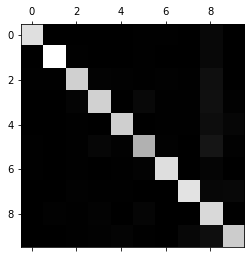

In [82]:
# 오차 행렬 시각화
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

> 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 성능이 좋아보임
- 숫자 5가 다른 숫자보다 조금 더 어두워보임: 숫자 5의 이미지가 적거나 / 숫자 5를 다른 숫자만큼 잘 분류하지 못함을 의미
  + 그래프의 에러 부분에 초점: 오차 행렬의 각 값을 클래스의 이미지 개수로 나누어 에러 비율 비교(에러 개수 사용 x)

In [84]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

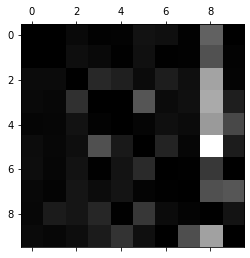

In [86]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

> 분류기의 에러 확인 가능
- 행: 실제 클래스 / 열: 예측한 클래스
  - 클래스 8 열이 밝으므로 많은 이미지가 8로 잘못 분류되었음을 의미
    + 그러나 클래스 8 행은 어두움: 실제 숫자 8은 숫자 8로 잘 분류
  - 숫자 3, 5가 서로 많이 혼동되고 있는 것 확인 가능


- 오차 행렬 분석을 통해 분류기의 성능 향상 방안에 대한 통찰 가능
- 그러나 개개의 에러를 분석하는 것은 어렵고 시간이 오래 걸림
  + 예를 들어 숫자 3과 5의 샘플 확인인

In [87]:
# 숫자 그림을 위한 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합침
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합침
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

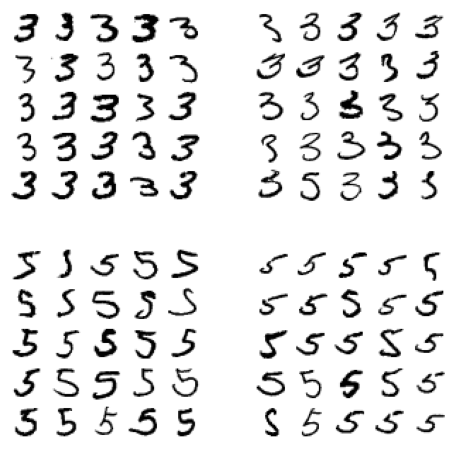

In [88]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

> - 왼쪽의 블록 두 개는 3으로 분류된 이미지, 오른쪽의 블록 두 개는 5로 분류된 이미지
    + 선형 모델인 SGDClassifier은 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산하는데, 3과 5는 몇 개의 픽셀만 다르기 떄문에 모델이 쉽게 혼동한 것

- 분류기는 이미지의 위치나 회전 방향에 민감하기 때문에, 에러를 줄이기 위해 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하여 해결 가능




--------------------------------
### **3.6 다중 레이블 분류**

분류기가 샘플마다 여러 개의 클래스를 출력해야 하는 경우도 존재 / 얼굴 인식 분류기
- 다중 레이블 분류(multilabel classification) 시스템: 여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [89]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [90]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [91]:
# 다중 레이블 분류기 평가(F1 score)
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

> 이 코드는 모든 레이블의 가중치가 같다고 가정
- 레이블에 클래스의 지지도(support)를 가중치로 지정하는 것도 가능: average="weighted"





-------------------

### **3.7 다중 출력 분류**
- 다중 출력 다중 클래스 분류(multioutput-multiclass classification): 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것, 값을 두 개 이상 가질 수 있음

  + 이미지에서 잡음을 제거하는 시스템 생성성

In [92]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

> 테스트 세트에서 이미지 하나 선택 후 이미지를 깨끗하게 변환환

In [93]:
some_index = 0

# 숫자 이미지를 그리는 함수
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

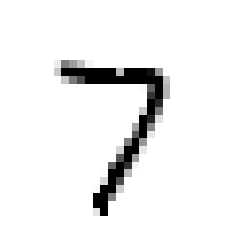

In [94]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)